In [1]:
import matplotlib.pyplot as plt

import numpy as np
import unittest
from scipy.constants import mu_0
from discretize.tests import check_derivative
import discretize

from SimPEG.electromagnetics import natural_source as nsem
from SimPEG.electromagnetics.static import utils as sutils
from SimPEG import (
    maps, utils, optimization, inversion, inverse_problem, directives,
    data_misfit, regularization, data
)
from discretize import TensorMesh
from pymatsolver import Pardiso
import gmsh
from scipy.spatial import cKDTree
# import pyvista as pv

def get_surface_weights(mesh, actind, values, octree=False):
    """
        Function that determines the surface weights to be applied
        either an octree or tensor mesh
        input: discretize mesh object: mesh
               numpy array: active domain cells
               numpy array: value of weights at each cell
                            at depth determined by size of array
    """
    n_layer = values.size

    uniqXYlocs, topoCC = sutils.gettopoCC(mesh, actind, option='center')

    tree = cKDTree(mesh.gridCC)

    if octree:
        d, inds = tree.query(np.c_[uniqXYlocs, topoCC])

    else:
        d, inds = tree.query(np.c_[uniqXYlocs.gridCC, topoCC])

    # Regularization (just for mesh use)
    regmap = maps.IdentityMap(nP=int(actind.sum()))

    reg = regularization.Sparse(
        mesh, indActive=actind,
        mapping=regmap
    )

    surface_weights_temp = np.ones(mesh.nC)
    surface_weights_temp[inds] = values[0]
    surface_weights = surface_weights_temp.copy()

    if n_layer > 1:

        for i in range(n_layer - 1):
            temp = np.zeros(mesh.nC)

            temp[actind] = reg.regmesh.aveFy2CC * reg.regmesh.cellDiffyStencil * surface_weights_temp[actind]

            inds = temp == 0.5

            surface_weights[inds] = values[i + 1]

    return surface_weights




[INFO] creating Tensor Mesh...
[NOTE] Active cells are being generated
[NOTE] Active cells completed
230 (9760,)
6755 (9760,) (160, 2) (9760,)
[1.00000000e-01 1.83298071e-01 3.35981829e-01 6.15848211e-01
 1.12883789e+00 2.06913808e+00 3.79269019e+00 6.95192796e+00
 1.27427499e+01 2.33572147e+01 4.28133240e+01 7.84759970e+01
 1.43844989e+02 2.63665090e+02 4.83293024e+02 8.85866790e+02
 1.62377674e+03 2.97635144e+03 5.45559478e+03 1.00000000e+04] (35, 2)


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.plotGrid has been deprecated, please use TensorMesh.plot_grid. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorNx has been deprecated, please use TensorMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


[ 2.47014634  0.37982946 -0.95394525 ... -1.18781528  0.8454181
 -0.17580935]


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.getInterpolationMat has been deprecated, please use TensorMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


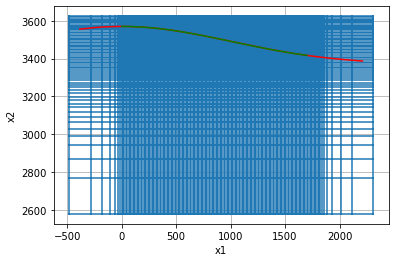

In [2]:
deriv_type = "sigma"
sim_type = "h"
fixed_boundary=True

    
print('[INFO] creating Tensor Mesh...')
mesh = discretize.TensorMesh(
[
    [(200,1),(100,1),(75,1),(50,1),(25,1),(20,1),(15,1),(12.5,146),(15,1),(20,1),(25,1),(50,1),(75,1),(100,1),(200,1)], #[(min cell size,left padding cells, growth factor),(min cell size, amount of cells @ that size),(min cell size,right padding cells, growth factor)]
    [(187.5,1),(100,1),(75,1),(50,1),(37.5,2),(25,3),(18.75,5),(12.5,5),(10,5),(8.75,10),(7.5,15),(6.25,12)]
], x0=[-485, 2580])

mesh.plotGrid()

b = 1000
A = 200

# create topography

Z = A * np.exp(-0.5 * ((mesh.vectorCCx / b) ** 2.0 )) + 3370

topo = np.vstack([mesh.vectorCCx, Z]).T


plt.plot(mesh.vectorCCx, Z, 'r')

print('[NOTE] Active cells are being generated')
actinds = utils.surface2ind_topo(mesh, topo, method='linear')       # active indicies
print('[NOTE] Active cells completed')


# create the synthetic model
sigma_back = 1e-2
sigma_right = 1e-1
sigma_porph = 1
sigma_basement = 1e-2
sigma_air = 1e-8

cells = mesh.cell_centers
sigma = np.ones(mesh.n_cells) * sigma_back
# Conductive sphere
x0 = 700
z0 = 3300
r0 = 100
csph = (
    np.sqrt(
        (mesh.gridCC[:, 0] - x0) ** 2.0
        + (mesh.gridCC[:, 1] - z0) ** 2.0
    )
) < r0
print(csph.sum(), csph.shape)
sigma[csph] = sigma_porph
sigma[cells[:, 1] <= 3200] = sigma_basement
sigma[~actinds] = sigma_air
# sigma = np.log(sigma)


print(actinds.sum(), actinds.shape, topo.shape, sigma.shape)

actmap = maps.InjectActiveCells(

    mesh, indActive=actinds, valInactive=np.log(1e-8)

)

if deriv_type == "sigma":
    sim_kwargs = {"sigmaMap": maps.ExpMap() * actmap}
    test_mod = np.log(sigma)
else:
    sim_kwargs = {"muMap": maps.ExpMap(), "sigma": sigma}
    test_mod = np.log(mu_0) * np.ones(mesh.n_cells)

frequencies = np.logspace(-1, 4, 20)

z_flight_height = A * np.exp(-0.5 * ((np.linspace(0, 1700, 35) / b) ** 2.0 )) + 3370


rx_locs = np.c_[np.linspace(0, 1700, 35), z_flight_height]

plt.plot(rx_locs[:, 0], rx_locs[:, 1], 'g')

print(frequencies, rx_locs.shape)


# if fixed_boundary:

#     actmap = maps.InjectActiveCells(

#         mesh, indActive=actinds, valInactive=np.log(1e-8)

#     )

#     # get field from 1D simulation
#     survey_1d = nsem.Survey(
#         [nsem.sources.Planewave([], frequency=f) for f in frequencies]
#     )
#     mesh_1d = TensorMesh([mesh.h[1]], [mesh.origin[1]])
#     sim_1d = nsem.simulation.Simulation1DMagneticField(
#         mesh_1d, survey=survey_1d, sigmaMap=maps.IdentityMap()
#     )

#     b_left, b_right, _, __ = mesh.cell_boundary_indices
#     f_left = sim_1d.fields(sigma[b_left])
#     f_right = sim_1d.fields(sigma[b_right])

#     b_e = mesh.boundary_edges
#     top = np.where(b_e[:, 1] == mesh.nodes_y[-1])
#     left = np.where(b_e[:, 0] == mesh.nodes_x[0])
#     right = np.where(b_e[:, 0] == mesh.nodes_x[-1])
#     e_bc = {}
#     for src in survey_1d.source_list:
#         e_bc_freq = np.zeros(mesh.boundary_edges.shape[0], dtype=np.complex)
#         e_bc_freq[top] = 1.0
#         e_bc_freq[right] = f_right[src, "e"][:, 0]
#         e_bc_freq[left] = f_left[src, "e"][:, 0]
#         e_bc[src.frequency] = e_bc_freq
#     sim_kwargs["e_bc"] = e_bc

rx_list = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="real"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="imag"
    ),
#     nsem.receivers.Point3DTipper(
#         rx_locs, orientation="zx", component="imag"
#     ),
#     nsem.receivers.PointNaturalSource(
#         rx_locs, orientation="yx", component="apparent_resistivity"
#     ),
#     nsem.receivers.PointNaturalSource(
#         rx_locs, orientation="yx", component="phase"
#     ),
]

src_list = [nsem.sources.Planewave(rx_list, frequency=f) for f in frequencies]

survey = nsem.Survey(src_list)

sim = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey,
    **sim_kwargs,
    solver=Pardiso,
)

data_obs = sim.dpred(np.log(sigma[actinds]))

data_obs = data_obs + (np.random.randn(data_obs.shape[0]) * (data_obs * 0.05))
print(np.random.randn(data_obs.shape[0]))

In [ ]:
# simplex mesh design

gmsh.initialize()

gmsh.clear()
gmsh.model.add("t3")


# add the points defining the mesh outline

# add lower points
lc = 100
gmsh.model.occ.addPoint(-500, 2600, 0, lc, 1)
gmsh.model.occ.addPoint(2210, 2600, 0, lc, 2)

# create the top points
gmsh.model.occ.addPoint(-500, 3650, 0, lc, 4)
gmsh.model.occ.addPoint(2210, 3650, 0, lc, 3)


lc = 12.5
gmsh.model.occ.addPoint(-500, topo[0, 1], 0, lc, 29)
cnt = 0
for ii in range(topo.shape[0]):

    if ii == 0:
        
        first = gmsh.model.occ.addPoint(topo[ii, 0], topo[ii, 1], 0, lc, ii + 30)
        first_pt = ii + 30
        
    else:
        
        if ii == topo.shape[0]-1:
            
            last = ii + 30
    
        gmsh.model.occ.addPoint(topo[ii, 0], topo[ii, 1], 0, lc, ii + 30)
    
    cnt += 1
    
    # create outterbox
gmsh.model.occ.addLine(1, first_pt - 1, 1000)
gmsh.model.occ.addLine(first_pt - 1, 4, 1001)
gmsh.model.occ.addLine(4, 3, 1002)
gmsh.model.occ.addLine(3, last, 1003)
gmsh.model.occ.addLine(last, 2, 1004)
gmsh.model.occ.addLine(2, 1, 1005)

surface = np.arange(29, ii + 31)
print(surface)
surface_list = surface.tolist()
p = gmsh.model.occ.addSpline(surface_list, 100)

gmsh.model.occ.addCurveLoop([1000, 1001, 1002, 1003, 1004, 1005], 1)
s = gmsh.model.occ.addPlaneSurface([1], 1111)
gmsh.model.occ.synchronize()

gmsh.model.mesh.embed(1, [p], 2, 1111)


# gmsh.model.occ.synchronize()
# gmsh.model.addPhysicalGroup(1, [1, 2, 4], 5)
# ps = gmsh.model.addPhysicalGroup(2, [1])
# gmsh.model.setPhysicalName(2, ps, "My surface")

# We can then generate a 2D mesh...
gmsh.model.mesh.generate(2)

# # ... and save it to disk
gmsh.write("t1.vtk")

# Creates  graphical user interface
gmsh.fltk.run()
  


In [ ]:
# # assign error
# rs_error = np.reshape(data_obs, (rx_locs.shape[0] * 2, frequencies.shape[0]))
# print(rs_error.shape)

# # set some extended use variables
# num_sites = rx_locs.shape[0]

# eps = 5

# for ii in range(rs_error.shape[1]):
    
# #     eps = np.percentile(rs_error[:num_sites, ii], 10)
#     std_r = 0.1
#     std_i = 0.1
    
#     rs_error[:num_sites, ii] = np.abs(rs_error[:num_sites, ii]) * std_r + eps
#     rs_error[num_sites:, ii] = np.abs(rs_error[num_sites:, ii]) * std_i + 10
    
# std = rs_error.flatten('F')
# print(std[:5], rs_error[:5, 0])

(9760,) 6755 (9760,) (160, 2) (9760,) 9760


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/mixins/mpl_mod.py:294: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


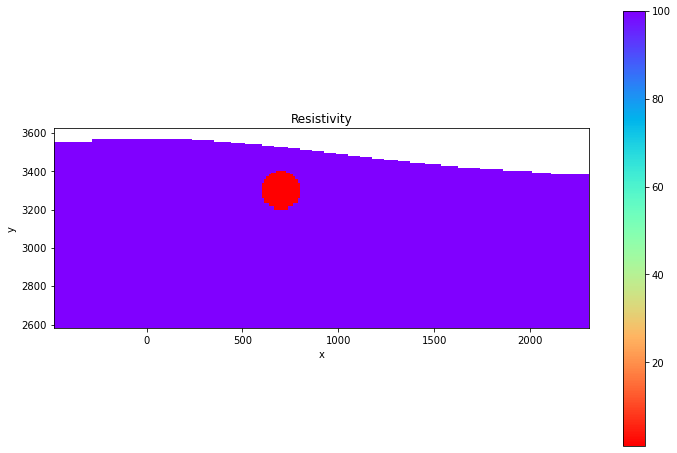

In [3]:
# ==========================================================================================
# Plot synthetic model

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mtrue = sigma  # np.ones(mesh.nC) * 1 / np.median(rho_app)                        # conductivity
mtrue[~actinds] = np.nan
clim = [0, 0.1]
print(mtrue.shape, actinds.sum(), actinds.shape, topo.shape, sigma.shape, mesh.nC)

dat = mesh.plot_image((1 / (mtrue)), ax=ax, grid=False,
#                      gridOpts={'alpha': 0.2},
                     pcolorOpts={"cmap": "rainbow_r"}
                    )
ax.set_title('Resistivity')
cb = plt.colorbar(dat[0], ax=ax)
# ax.set_xlim([-300, 4300])
# ax.set_ylim([-400, 0])
ax.set_aspect('equal')
# ax.plot(
#     survey_dc.electrode_locations[:, 0],
#     survey_dc.electrode_locations[:, 1], 'k.'
# )
plt.show()

# np.save('conductivity.npy', rho_est)

(1400,)


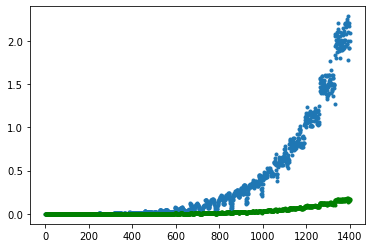

In [4]:
eps = 1e-5
std = abs(data_obs * 0.08) + eps
# plt.loglog(frequencies, data_obs[:20], '.')
plt.plot(data_obs, '.')
print(data_obs.shape)
plt.plot(std, '.g')

In [13]:
active_cells = actinds
#np.percentile(np.abs(data_obs), 10, interpolation='lower')
m0 = (np.ones(mesh.nC) * np.log(sigma_back))[actinds]
# m0[~actinds] = np.log(1e-8)
# std = abs(data_obs * 0.05) + eps
data_t = data.Data(survey, dobs=data_obs, standard_deviation=std)
# Clean sensitivity function formed with true resistivity
sim._Jmatrix = None

# Data Misfit
coolingFactor = 2
coolingRate = 1
beta0_ratio = 1e1
dmisfit = data_misfit.L2DataMisfit(data=data_t, simulation=sim)

# check for percentile floor

# print(uncert.shape)
dmisfit.W = 1. / std
# Map for a regularization
regmap = maps.IdentityMap(nP=int(actinds.sum()))
# reg = regularization.Tikhonov(mesh, indActive=actinds, mapping=regmap)
reg = regularization.Sparse(mesh, indActive=actinds, mapping=regmap)

# w_fac = np.asarray([25, 10, 5])


# surface_weights = get_surface_weights(mesh, active_cells, w_fac, octree=False)

# # Related to inversion
# reg.cell_weights = 1 / (mesh.vol[active_cells] * surface_weights[active_cells])

print('[INFO] Getting things started on inversion...')
# set alpha length scales
reg.alpha_s = 1
reg.alpha_x = 1
reg.alpha_y = 1
reg.alpha_z = 1
# plot uncertainties
# opt = Optimization.InexactGaussNewton(maxIter=6)
# opt = Optimization.GaussNewton(maxIter=15)
opt = optimization.ProjectedGNCG(maxIter=10, upper=np.inf, lower=-np.inf)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
beta = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=coolingRate
)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
target = directives.TargetMisfit()
target.target = survey.nD / 2.
saveIter = directives.SaveModelEveryIteration()
saveIterVar = directives.SaveOutputEveryIteration()

directiveList = [
    beta, betaest, target  # , saveIter, saveIterVar 
]

inv = inversion.BaseInversion(
    invProb, directiveList=directiveList)
# opt.LSshorten = 0.5
opt.remember('xc')

# Run Inversion ======================================================
minv = inv.run(m0)

[INFO] Getting things started on inversion...
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh._cellGradxStencil has been deprecated, please use TensorMesh.stencil_cell_gradient_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh._cellGradyStencil has been deprecated, please use TensorMesh.stencil_cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.39e-03  3.72e+04  0.00e+00  3.72e+04    5.50e+02      0              
   1  2.19e-03  6.45e+03  6.41e+05  7.85e+03    2.85e+02      0              
   2  1.10e-03  1.63e+03  9.18e+05  2.64e+03    2.82e+02      0              
   3  5.48e-04  1.35e+03  7.73e+05  1.77e+03    2.97e+02      1              
   4  2.74e-04  1.07e+03  6.36e+05  1.25e+03    3.25e+02      1   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.7243e+03
1 : |xc-x_last| = 1.7379e+01 <= tolX*(1+|x0|) = 3.7949e+01
0 : |proj(x-g)-x|    = 3.2482e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.2482e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter

/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/mixins/mpl_mod.py:294: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


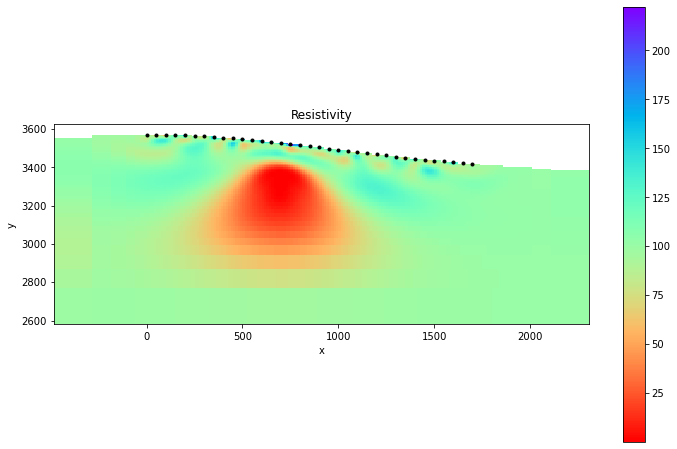

In [14]:
# ==========================================================================================
# Plot inversion results
rho_est = actmap * minv
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mtrue = 1 / np.exp(rho_est)  # np.ones(mesh.nC) * 1 / np.median(rho_app)                        # conductivity
mtrue[~actinds] = np.nan
clim = [0, 5]

dat = mesh.plotImage(mtrue, ax=ax, grid=False,
                     pcolorOpts={"cmap": "rainbow_r"}
                    )
ax.set_title('Resistivity')
cb = plt.colorbar(dat[0], ax=ax)
# ax.set_xlim([-300, 4300])
# ax.set_ylim([-400, 0])
ax.set_aspect('equal')
ax.plot(
    rx_locs[:, 0],
    rx_locs[:, 1], 'k.'
)
plt.show()

np.save('conductivity.npy', rho_est)

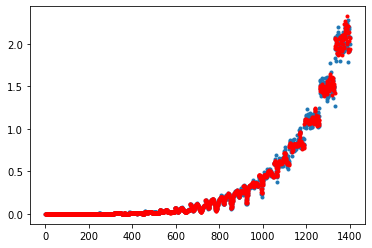

In [15]:
plt.plot(data_obs, '.')
plt.plot(invProb.dpred, '.r')